In [3]:
# Setup
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.1.0


In [4]:
# Download the IMDB dataset
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Shuffling and writing examples to /Users/yuri/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteA8U1B5/imdb_reviews-train.tfrecord
Shuffling and writing examples to /Users/yuri/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteA8U1B5/imdb_reviews-test.tfrecord
Shuffling and writing examples to /Users/yuri/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteA8U1B5/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /Users/yuri/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [6]:
# Try the encoder
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

# Vocabulary size: 8185 -> 8185 개로 인코딩이 되어있다. 숫자가 정해져 있다는 의미이다. 

Vocabulary size: 8185


In [7]:
# This text encoder will reversibly encode any string:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [ ]:
인코더는 그 단어가 사전에 없을 경우 그것을 하위 단어나 문자로 분해하여 문자열을 인코딩한다. 
따라서 문자열이 데이터 집합을 더 많이 닮을수록 인코딩된 표현은 더 짧아질 것이다.
왜 hello/thensorflow/로 안 끊었을까? subwordText 끊어주었기 때문에..그리고 OOV에 대한 처리

In [20]:
# Explore the data

for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [21]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [27]:
# Prepare the data for training
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, padded_shapes=([None],[])))

test_batches = (
    test_data
    .padded_batch(32, padded_shapes=([None],[])))

In [28]:
for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 1615)
label shape: (32,)
Batch shape: (32, 1101)
label shape: (32,)


In [29]:
# Build the model

model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the model

model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6805 - accuracy: 0.5011 - val_loss: 0.6607 - val_accuracy: 0.5083
Epoch 2/10
782/782 [==============================] - 3s 3ms/step - loss: 0.6143 - accuracy: 0.5612 - val_loss: 0.5884 - val_accuracy: 0.6219
Epoch 3/10
782/782 [==============================] - 3s 3ms/step - loss: 0.5339 - accuracy: 0.6752 - val_loss: 0.5286 - val_accuracy: 0.6479
Epoch 4/10
782/782 [==============================] - 3s 3ms/step - loss: 0.4686 - accuracy: 0.7564 - val_loss: 0.4768 - val_accuracy: 0.7688
Epoch 5/10
782/782 [==============================] - 3s 3ms/step - loss: 0.4163 - accuracy: 0.8076 - val_loss: 0.4404 - val_accuracy: 0.8156
Epoch 6/10
782/782 [==============================] - 3s 3ms/step - loss: 0.3752 - accuracy: 0.8376 - val_loss: 0.4135 - val_accuracy: 0.8062
Epoch 7/10
782/782 [==============================] - 3s 3ms/step - loss: 0.3438 - accuracy: 0.8554 - val_loss: 0.3939 - val_accuracy: 0.8531
Epoch 

In [31]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

    782/Unknown - 3s 3ms/step - loss: 0.3302 - accuracy: 0.8667Loss:  0.3301556345046786
Accuracy:  0.86668


In [32]:
# Create a graph of accuracy and loss over time

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

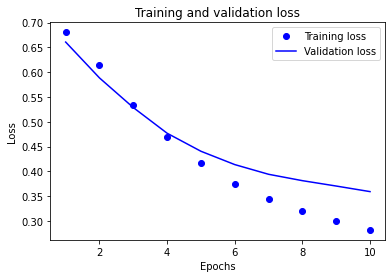

In [33]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

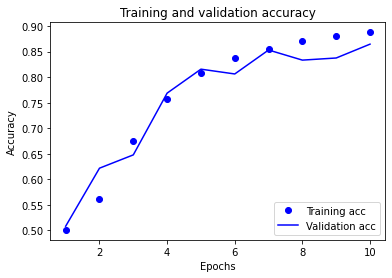

In [34]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()